# Using the `Signal` object

This demo shows how to store and access measurement data in the `bpwave.Signal` object.

Measurement data used here is the first 10000 data points of a human blood pressure [waveform](https://www.physionet.org/content/autonomic-aging-cardiovascular/1.0.0/0027.dat) obtained with non-invasive continuous measurement, downloaded form the [Autonomic Aging](https://www.physionet.org/content/autonomic-aging-cardiovascular/1.0.0/) dataset of PhysioNet.

*   Schumann, A., & Bär, K. (2021).
    Autonomic Aging: A dataset to quantify changes of cardiovascular autonomic
    function during healthy aging (version 1.0.0). PhysioNet.
    https://doi.org/10.13026/2hsy-t491.

*   Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000).
    PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals.
    Circulation [Online]. 101 (23), pp. e215–e220.

In [1]:
import bpwave
import numpy as np
import h5py
import pathlib as pl
import matplotlib.pyplot as plt

In [2]:
bpwave.__version__

'0.0.3'

## Construct signals from `y` and `t` or `fs`

First, we'll load the example data located at the test folder.

In [3]:
folder = pl.Path.cwd().parent / "tests" / "data"

In [4]:
test_data = {}
for p in folder.glob("physionet_aac_0027_10000_*.csv"):
  test_data[p.stem.replace("physionet_aac_0027_10000_", "")] = np.loadtxt(p).astype(float if p.stem.endswith("_y") else int)
  print(f"Loaded {p.name}.")

Loaded physionet_aac_0027_10000_dicr_notch.csv.
Loaded physionet_aac_0027_10000_dicr_peak.csv.
Loaded physionet_aac_0027_10000_sys_peak.csv.
Loaded physionet_aac_0027_10000_onset.csv.
Loaded physionet_aac_0027_10000_refl_peak.csv.
Loaded physionet_aac_0027_10000_y.csv.


These files contain the signal values `y` (recorded with 1000 Hz) and some characteristic points from manual annotation. Although the onsets of the reflected waves are clearly visible on this sample waveform, we intentionally didn't include their indices here, to show how missing data is handled.

In [5]:
test_data

{'dicr_notch': array([1050, 1790, 2560, 3350, 4160, 4980, 5820, 6640, 7470, 8280, 9070,
        9850]),
 'dicr_peak': array([1130, 1880, 2640, 3430, 4240, 5070, 5910, 6740, 7550, 8370, 9150,
        9930]),
 'sys_peak': array([ 800, 1550, 2310, 3100, 3910, 4730, 5570, 6410, 7220, 8030, 8820,
        9590]),
 'onset': array([ 720, 1470, 2230, 3020, 3830, 4650, 5490, 6320, 7140, 7950, 8740,
        9510]),
 'refl_peak': array([ 970, 1730, 2480, 3270, 4080, 4900, 5760, 6580, 7390, 8210, 9000,
        9770]),
 'y': array([94.0354667 , 94.46902553, 94.90258436, ..., 85.10203555,
        85.0534699 , 85.00402124])}

In [6]:
fs = 1000  # Hz
unit = "mmHg"

In this case, we only know the sampling frequency and don't know the exact timestamps. We can construct a `Signal` object the following way:

In [7]:
signal = bpwave.Signal(
  y=test_data["y"],
  unit=unit,
  fs=fs,
)
signal

<Signal of 10000 values>

The timestamps will be estimated from the sampling frequency, assuming uniform sampling:

In [8]:
timestamps = signal.t
timestamps

array([0.000e+00, 1.000e-03, 2.000e-03, ..., 9.997e+00, 9.998e+00,
       9.999e+00])

The property `t_from_fs` indicates that the timestamps were calculated, not provided in the constructor.

In [9]:
signal.t_from_fs

True

If we know the exact timestamps, `fs` will be calculated. The constructor accepts exactly one of `t` or `fs`. Timestamps are to be provided in seconds.

In [10]:
signal = bpwave.Signal(
  y=test_data["y"],
  unit=unit,
  t=timestamps,
)
f"{signal.fs=}, {signal.t_from_fs=}"

'signal.fs=1000.0, signal.t_from_fs=False'

Use `Signal.plot()` to see the waveform (When not in a notebook, `plt.show()` also needs to be called).

<Axes: xlabel='$t$ [s]', ylabel='$y$ [mmHg]'>

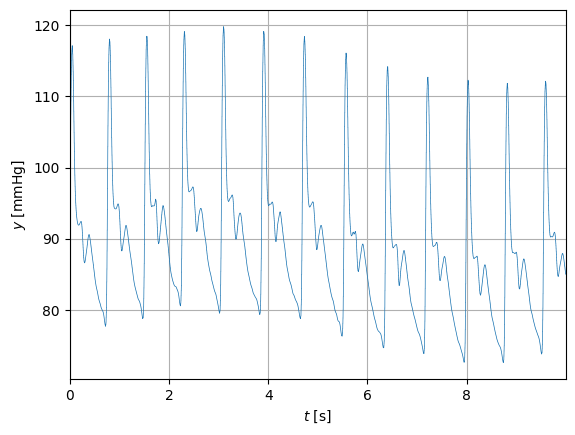

In [11]:
signal.plot()

The properties `t` and `fs` are readonly, but `y` can be updated with a new array matching the original size:

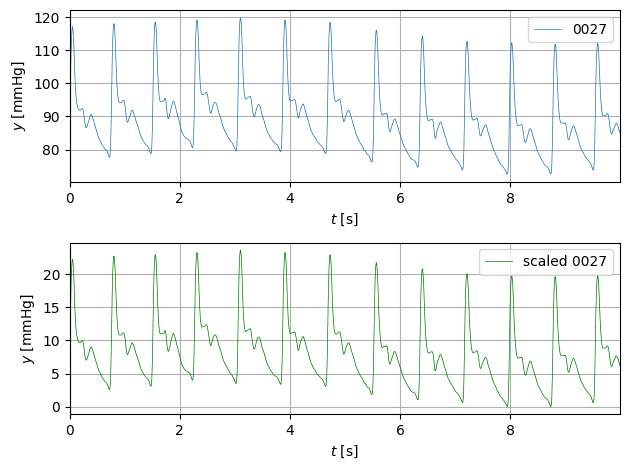

In [12]:
scaled = signal.copy(y=signal.y / 2)  # can be set in the `copy` arguments
scaled.y -= scaled.y.min()  # can be set as property as well
scaled.label = 'scaled 0027'
signal.label = '0027'
fig, (ax_orig, ax_scaled) = plt.subplots(nrows=2)
signal.plot(ax_orig)
scaled.plot(ax_scaled, 'g')
fig.tight_layout()

The signal can be serialized to HDF5 format:

In [13]:
out_folder = pl.Path.cwd() / "out"
out_folder.mkdir(exist_ok=True)

In [14]:
with h5py.File(out_folder / 'signal.hdf5', 'w') as f:
  signal.to_hdf(f)

In [15]:
with h5py.File(out_folder / 'signal.hdf5') as f:
  signal = bpwave.Signal.from_hdf(f)

## Describe data with `meta`, `marks` and `slices`

Store key-value metadata in `meta`. That `dict` is initialized by default, so it can be assigned by key.

In [16]:
signal.meta["source"] = "PhysioNet"
signal.meta.update({"start": 0, "stop": 10_000})
signal.meta

{'source': 'PhysioNet', 'start': 0, 'stop': 10000}

Named indices, such as events can be specified in `marks`. Multiple indices can be associated with the same key, so the value should be a list or an array. It will be internally converted to a `numpy` array.

In [17]:
signal.marks = {"global_max": [signal.y.argmax()]}
signal.marks["global_min"] = [signal.y.argmin()]
signal.marks["seconds"] = np.arange(0, len(signal.y), step=signal.fs, dtype=int)
signal.marks

{'global_max': array([3100]), 'global_min': array([8740]), 'seconds': array([   0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])}

`marks` are displayed on the plot, unless turned off with `marks=False`.

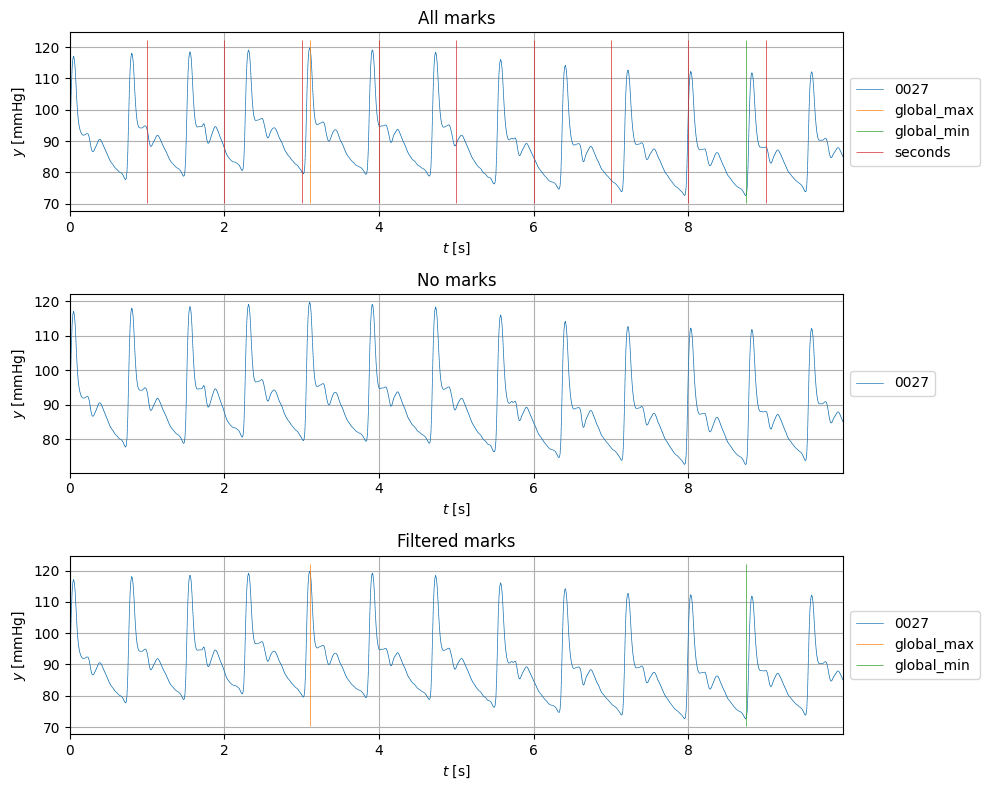

In [18]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 8))
signal.plot(axes[0], title="All marks", legend="outside")
signal.plot(axes[1], marks=False, title="No marks", legend="outside")
signal.plot(axes[2], marks={"global_min", "global_max"}, title="Filtered marks", legend="outside")  # Filtering by name
fig.tight_layout()

`slices` can be used to annotate sections, defined by start (inclusive) and stop (exclusive) indices. You can store a list of slices for one key.

In [19]:
signal.slices["first_second"] = [slice(signal.t2i(0), signal.t2i(1))]
signal.slices["overlapping"] = [slice(signal.t2i(0), signal.t2i(1.5)), slice(signal.t2i(1), signal.t2i(2.5))]
signal.slices

{'first_second': [slice(0, 1000, None)], 'overlapping': [slice(0, 1500, None), slice(1000, 2500, None)]}

`Signal.plot` doesn't display slices as they may take up too much space on the plot. We provide `bpwave.visu.plot_signal_slices` for visualization, that produces a figure with two subplots.

(<Axes: ylabel='$y$ [mmHg]'>, <Axes: xlabel='$t$ [s]'>)

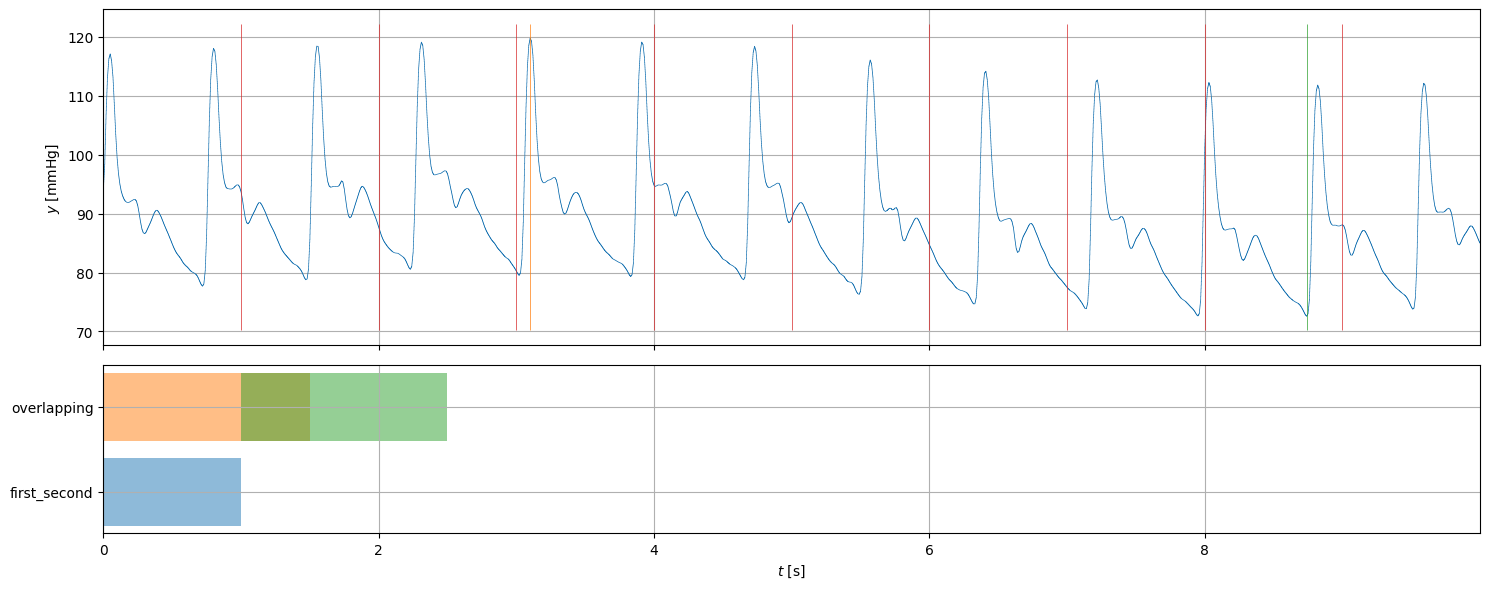

In [20]:
bpwave.visu.plot_signal_slices(signal)

## Store characteristic points in `chpoints`

You can annotate the waveform with characteristic points using the `chpoints` property.

Characteristic points currently supported can be found in the class `CpIndices`.
The type of `chpoints`, `ChPoints`, also contain algorithm metadata to document how the annotation was created.
`CpIndices` instances are immutable, use `dataclasses.replace()` to change fields.

In [21]:
signal.chpoints = bpwave.ChPoints(
  indices=[
    bpwave.CpIndices(onset=o, sys_peak=s, refl_peak=r, dicr_notch=dn, dicr_peak=dp)
    for (o, s, r, dn, dp) in zip(
      test_data["onset"],
      test_data["sys_peak"],
      test_data["refl_peak"],
      test_data["dicr_notch"],
      test_data["dicr_peak"],
    )
  ],
  alg="your.module.Algorithm",
  version="0.1.0",
  params={},
)
signal.chpoints.indices

[CpIndices(onset=720, sys_peak=800, refl_onset=-1, refl_peak=970, dicr_notch=1050, dicr_peak=1130),
 CpIndices(onset=1470, sys_peak=1550, refl_onset=-1, refl_peak=1730, dicr_notch=1790, dicr_peak=1880),
 CpIndices(onset=2230, sys_peak=2310, refl_onset=-1, refl_peak=2480, dicr_notch=2560, dicr_peak=2640),
 CpIndices(onset=3020, sys_peak=3100, refl_onset=-1, refl_peak=3270, dicr_notch=3350, dicr_peak=3430),
 CpIndices(onset=3830, sys_peak=3910, refl_onset=-1, refl_peak=4080, dicr_notch=4160, dicr_peak=4240),
 CpIndices(onset=4650, sys_peak=4730, refl_onset=-1, refl_peak=4900, dicr_notch=4980, dicr_peak=5070),
 CpIndices(onset=5490, sys_peak=5570, refl_onset=-1, refl_peak=5760, dicr_notch=5820, dicr_peak=5910),
 CpIndices(onset=6320, sys_peak=6410, refl_onset=-1, refl_peak=6580, dicr_notch=6640, dicr_peak=6740),
 CpIndices(onset=7140, sys_peak=7220, refl_onset=-1, refl_peak=7390, dicr_notch=7470, dicr_peak=7550),
 CpIndices(onset=7950, sys_peak=8030, refl_onset=-1, refl_peak=8210, dicr_no

Note that as our test data didn't contain the onsets of the reflected waves, these points are unset in the objects.

To filter out missing values, use `CpIndices.without_unset()`:

In [22]:
signal.chpoints.indices[0].without_unset()

{'onset': 720,
 'sys_peak': 800,
 'refl_peak': 970,
 'dicr_notch': 1050,
 'dicr_peak': 1130}

To convert the indices to a `numpy` array, use `CpIndices.to_array()`. This format keeps missing values, so that the same index correspond to the same characteristic point.

In [23]:
signal.chpoints.indices[0].to_array()

array([ 720,  800,   -1,  970, 1050, 1130])

As the onsets of cardiac cycles are frequently needed, they are accessible using the readonly shorthand property `Signal.onsets`:

In [24]:
signal.onsets

array([ 720, 1470, 2230, 3020, 3830, 4650, 5490, 6320, 7140, 7950, 8740,
       9510])

`chpoints` are also displayed on the plot and can be controlled similarly to `marks`.

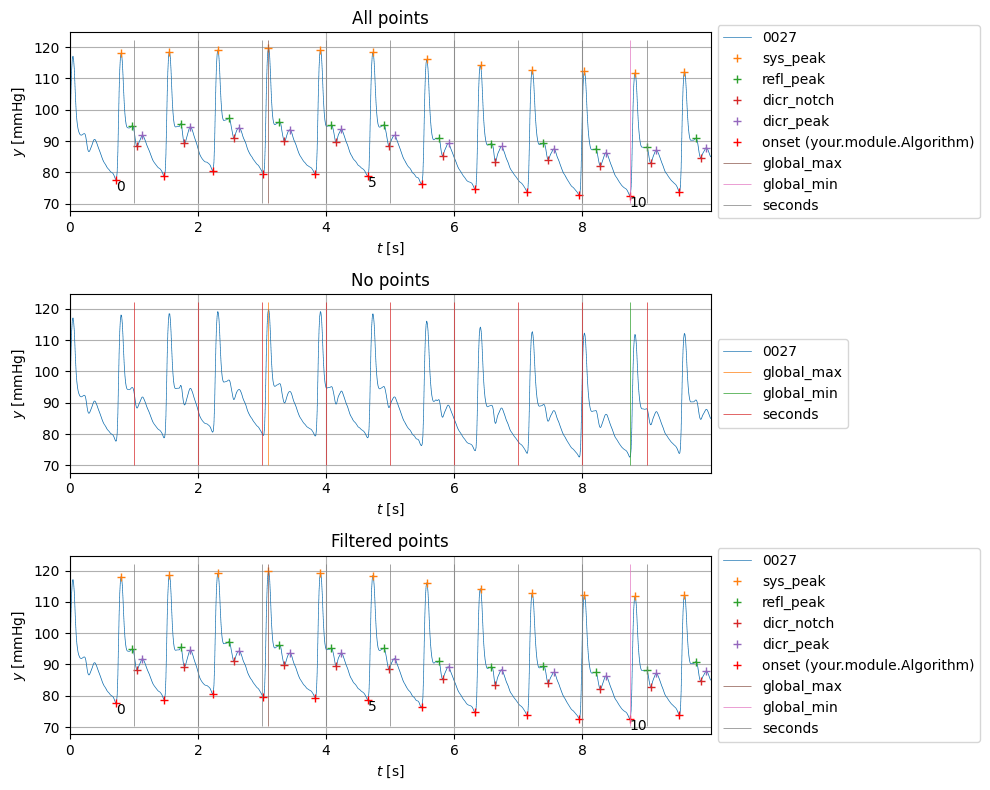

In [25]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 8))
signal.plot(axes[0], title="All points", legend="outside")
signal.plot(axes[1], points=False, onsets=False, title="No points", legend="outside")
signal.plot(axes[2], points={"refl_peak", "dicr_peak"}, title="Filtered points", legend="outside")
fig.tight_layout()

## `Signal`s can be sliced by index, by time or by cardiac cycle

Select a range by index using the `[]` operator.

Note that in this case this is a view, the original timestamps are preserved. Use `.copy()` and `.shift_t()` to create a new instance with `t` starting from 0.

<Axes: xlabel='$t$ [s]', ylabel='$y$ [mmHg]'>

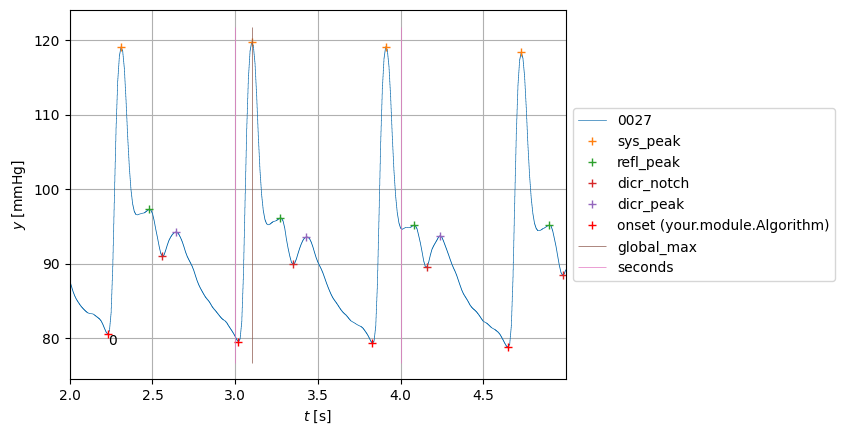

In [26]:
signal[2000:5000].plot(legend="outside")

Cardiac cycles are determined by the `onsets` property, which in turn relies on `chpoints`.

In [27]:
list(signal.iter_ccycle_slices())

[slice(720, 1470, None),
 slice(1470, 2230, None),
 slice(2230, 3020, None),
 slice(3020, 3830, None),
 slice(3830, 4650, None),
 slice(4650, 5490, None),
 slice(5490, 6320, None),
 slice(6320, 7140, None),
 slice(7140, 7950, None),
 slice(7950, 8740, None),
 slice(8740, 9510, None)]

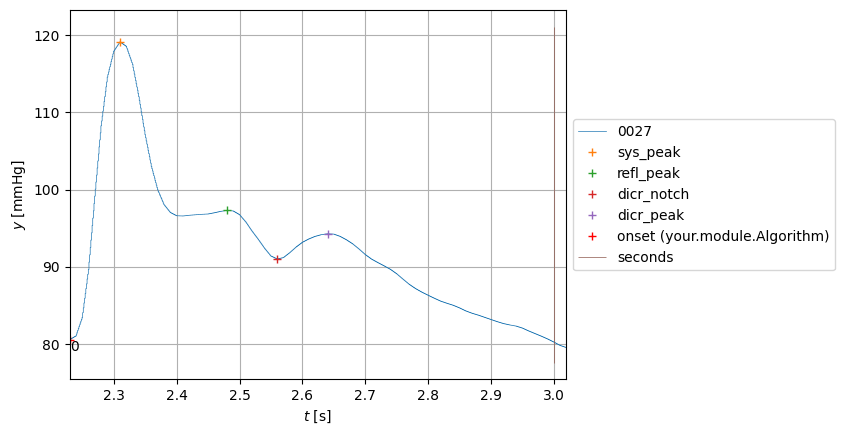

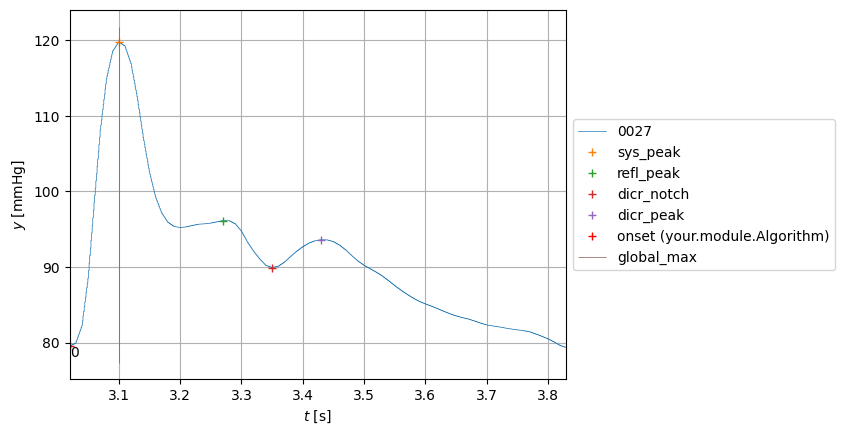

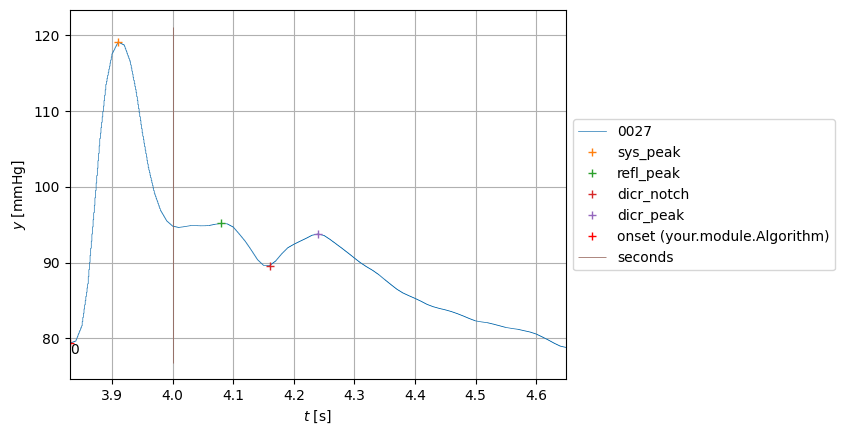

In [28]:
for cycle in signal[2000:5000].iter_ccycles():
  cycle.plot(legend="outside")

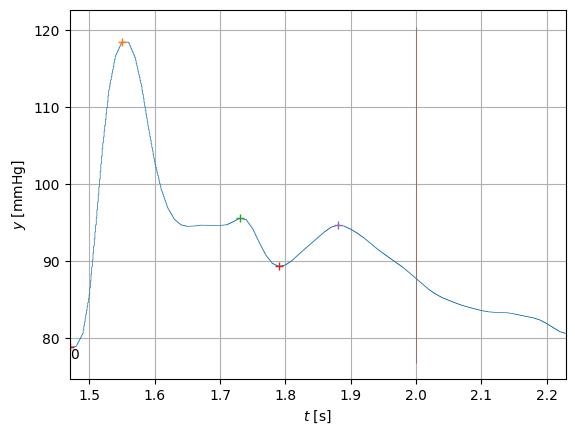

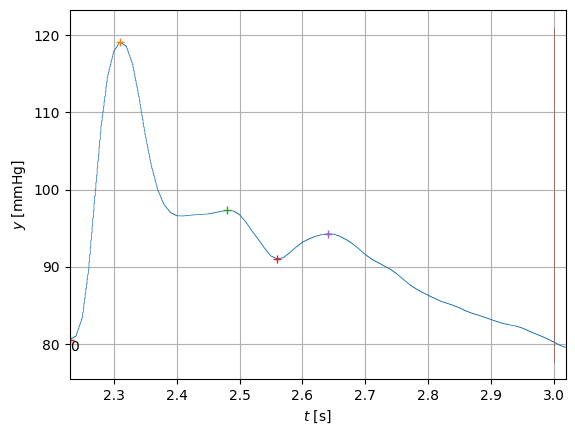

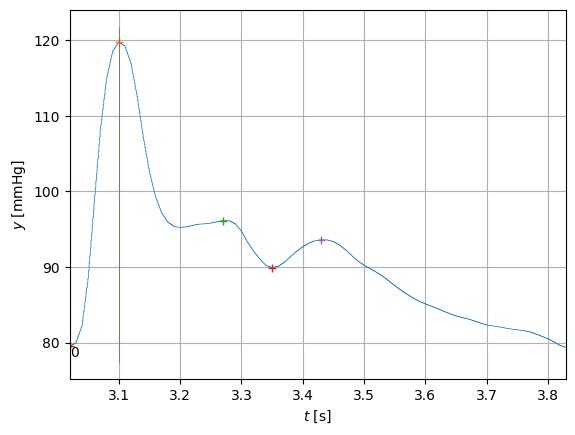

In [29]:
for cc in signal.ccycles[1:4]:
  cc.plot(legend="off")

For slicing by time in seconds, use `by_t`.

<Axes: xlabel='$t$ [s]', ylabel='$y$ [mmHg]'>

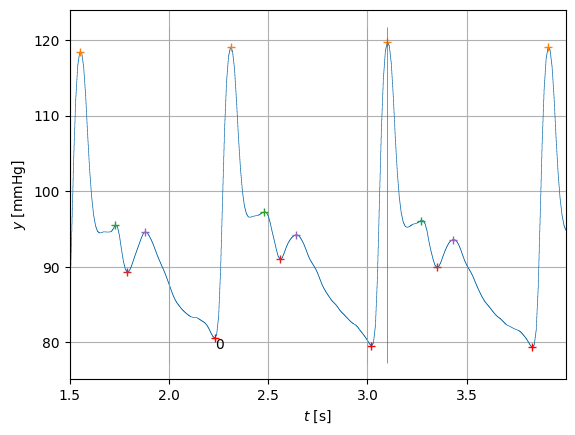

In [30]:
signal.by_t[1.5:4].plot(legend="off")

To select a range by onset indices, use `by_onset`. In this case, the onset specified as end is included.

<Axes: xlabel='$t$ [s]', ylabel='$y$ [mmHg]'>

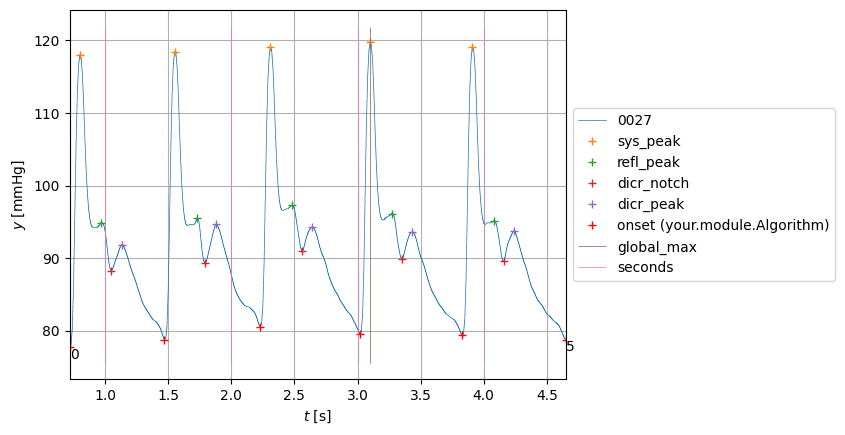

In [31]:
signal.by_onset[:5].plot(legend="outside")